In [4]:
!pip install pathway bokeh --quiet

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn
import os
import warnings
warnings.filterwarnings('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')

Mounted at /content/drive


In [7]:
df

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...
18363,18363,Shopping,1920,26.150504,91.733531,1517,truck,average,6,0,19-12-2016,14:30:00
18364,18364,Shopping,1920,26.150504,91.733531,1487,car,low,3,0,19-12-2016,15:03:00
18365,18365,Shopping,1920,26.150504,91.733531,1432,cycle,low,3,0,19-12-2016,15:29:00
18366,18366,Shopping,1920,26.150504,91.733531,1321,car,low,2,0,19-12-2016,16:03:00


In [8]:
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')
df = df.sort_values('Timestamp').reset_index(drop=True)

df[["Timestamp", "Occupancy", "Capacity"]].to_csv("df_model1.csv", index=False)
df[['ID', 'Capacity', 'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay', 'Timestamp']].to_csv("df_model2.csv", index=False)
df[['ID', 'Capacity', 'Occupancy', 'Latitude', 'Longitude', 'VehicleType', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay', 'Timestamp']].to_csv("df_model3.csv", index=False)

In [9]:
fname1 = "df_model1.csv"
schema1 = pw.schema_from_csv(fname1)
# data1 = pw.io.csv.read(fname, schema=schema, mode="static")
data1 = pw.demo.replay_csv(fname1, schema=schema1, input_rate=9000)
data1

<pathway.Table schema={'Timestamp': <class 'str'>, 'Occupancy': <class 'int'>, 'Capacity': <class 'int'>}>

In [10]:
fname2 = "df_model2.csv"
schema2 = pw.schema_from_csv(fname2)
# data2 = pw.io.csv.read(fname, schema=schema, mode="static")
data2 = pw.demo.replay_csv(fname2, schema=schema2, input_rate=9000)
data2

<pathway.Table schema={'ID': <class 'int'>, 'Capacity': <class 'int'>, 'Occupancy': <class 'int'>, 'VehicleType': <class 'str'>, 'TrafficConditionNearby': <class 'str'>, 'QueueLength': <class 'int'>, 'IsSpecialDay': <class 'int'>, 'Timestamp': <class 'str'>}>

In [11]:
fname3 = "df_model3.csv"
schema3 = pw.schema_from_csv(fname3)
# data3 = pw.io.csv.read(fname, schema=schema, mode="static")
data3 = pw.demo.replay_csv(fname3, schema=schema3, input_rate=9000)
data3

<pathway.Table schema={'ID': <class 'int'>, 'Capacity': <class 'int'>, 'Occupancy': <class 'int'>, 'Latitude': <class 'float'>, 'Longitude': <class 'float'>, 'VehicleType': <class 'str'>, 'TrafficConditionNearby': <class 'str'>, 'QueueLength': <class 'int'>, 'IsSpecialDay': <class 'int'>, 'Timestamp': <class 'str'>}>

**Model 1: Baseline Linear Model**

In [12]:
import datetime


fmt = "%Y-%m-%d %H:%M:%S"

data_with_time1 = data1.with_columns(
    t = data1.Timestamp.dt.strptime(fmt),
    day = data1.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)

delta_window = (
    data_with_time1.windowby(
        pw.this.t,  # Event time column to use for windowing (parsed datetime)
        instance=pw.this.day,  # Logical partitioning key: one instance per calendar day
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),  # Fixed-size daily window
        behavior=pw.temporal.exactly_once_behavior()  # Guarantees exactly-once processing semantics
    )
    .reduce(
        t=pw.this._pw_window_end,                        # Assign the end timestamp of each window
        occ_max=pw.reducers.max(pw.this.Occupancy),      # Highest occupancy observed in the window
        occ_min=pw.reducers.min(pw.this.Occupancy),      # Lowest occupancy observed in the window
        cap=pw.reducers.max(pw.this.Capacity),           # Maximum capacity observed (typically constant per spot)
    )
    .with_columns(
        # Compute the price using a simple dynamic pricing formula:
        #
        # Pricing Formula:
        #     price = base_price + demand_fluctuation
        #     where:
        #         base_price = 10 (fixed minimum price)
        #         demand_fluctuation = (occ_max - occ_min) / cap
        #
        # Intuition:
        # - The greater the difference between peak and low occupancy in a day,
        #   the more volatile the demand is, indicating potential scarcity.
        # - Dividing by capacity normalizes the fluctuation (to stay in [0,1] range).
        # - This fluctuation is added to the base price of 10 to set the final price.
        # - Example: If occ_max = 90, occ_min = 30, cap = 100
        #            => price = 10 + (90 - 30)/100 = 10 + 0.6 = 10.6

        price=10 + (pw.this.occ_max - pw.this.occ_min) / pw.this.cap
    )
)

# Activate the Panel extension to enable interactive visualizations
pn.extension()

# Define a custom Bokeh plotting function that takes a data source (from Pathway) and returns a figure
def price_plotter(source):
    # Create a Bokeh figure with datetime x-axis
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Model 1: Baseline Linear Model",
        x_axis_type="datetime",  # Ensure time-based data is properly formatted on the x-axis
    )
    # Plot a line graph showing how the price evolves over time
    fig.line("t", "price", source=source, line_width=2, color="navy")

    # Overlay red circles at each data point for better visibility
    fig.circle("t", "price", source=source, size=6, color="red")

    return fig

# Use Pathway's built-in .plot() method to bind the data stream (delta_window) to the Bokeh plot
# - 'price_plotter' is the rendering function
# - 'sorting_col="t"' ensures the data is plotted in time order
viz = delta_window.plot(price_plotter, sorting_col="t")

# Create a Panel layout and make it servable as a web app
# This line enables the interactive plot to be displayed when the app is served
pn.Column(viz).servable()


Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

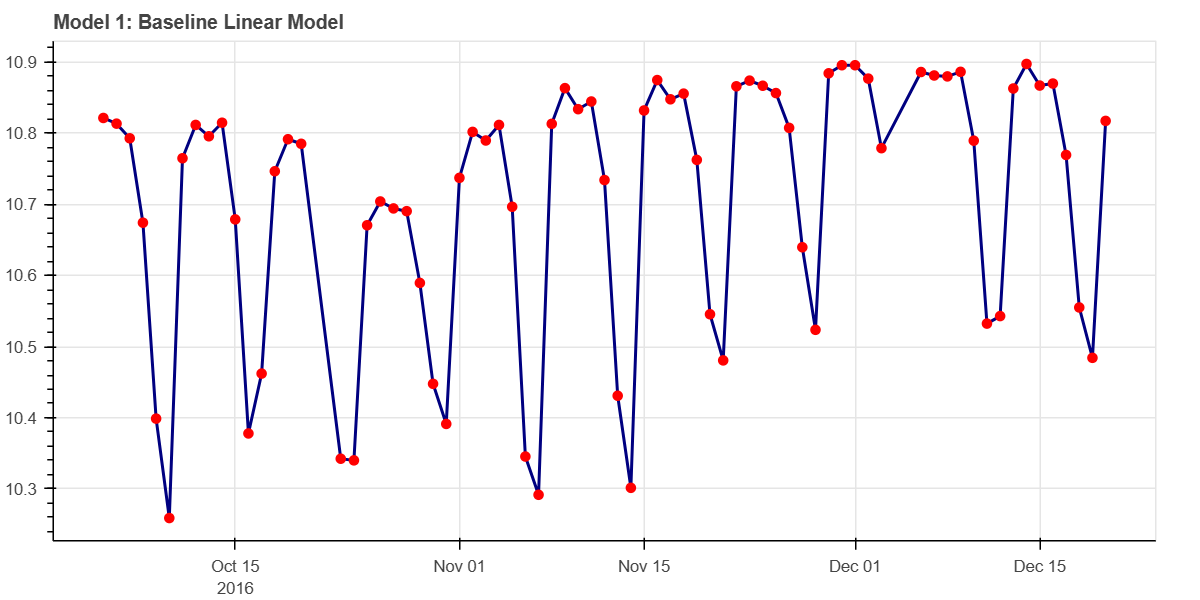

In [18]:
# %%capture --no-display
# pw.run()

Output()

**Model 2: Demand-Based Price Function**

In [14]:
import pathway as pw
import datetime
import panel as pn
import bokeh.plotting

fmt = "%Y-%m-%d %H:%M:%S"
data_with_time2 = data2.with_columns(
    t = data2.Timestamp.dt.strptime(fmt=fmt),
    day = data2.Timestamp.dt.strptime(fmt=fmt).dt.strftime("%Y-%m-%dT00:00:00"),
)

alpha = 0.4
beta = 0.1
gamma = 0.15
delta = 0.1
epsilon = 0.05
base_price = 10.0
lambda_val = 0.7

data_casted = data_with_time2.with_columns(
    occupancy_f = pw.cast(float, data_with_time2.Occupancy),
    capacity_f = pw.cast(float, data_with_time2.Capacity),
    traffic_f = pw.apply_with_type(
        lambda x: 0.0 if str(x).lower() == "low"
            else 1.0 if str(x).lower() == "average"
            else 2.0 if str(x).lower() == "high"
            else float('nan'),
        float,
        data_with_time2.TrafficConditionNearby
    ),
    queue_f = pw.cast(float, data_with_time2.QueueLength),
    special_f = pw.cast(float, data_with_time2.IsSpecialDay),

    vehicle_weight = pw.if_else(
        data_with_time2.VehicleType == "car", 1.0,
        pw.if_else(
            data_with_time2.VehicleType == "bike", 0.5,
            pw.if_else(
                data_with_time2.VehicleType == "truck", 1.5,
                1.0
            )
        )
    )
)

data_demand = data_casted.with_columns(
    occ_ratio = pw.this.occupancy_f / pw.this.capacity_f,

    demand = (
        alpha * (pw.this.occupancy_f / pw.this.capacity_f) +
        beta * pw.this.queue_f +
        gamma * pw.this.traffic_f +
        delta * pw.this.special_f +
        epsilon * pw.this.vehicle_weight
    )
)


# Step 6: Window-wise average demand and price
window2_base = (
    data_demand.windowby(
        pw.this.t,
        instance=pw.this.day,
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t=pw.this._pw_window_end,
        avg_demand = pw.reducers.avg(pw.this.demand)
    )
)

window2_norm = window2_base.with_columns(
    normalized_demand = window2_base.avg_demand / 2.0
)

window2_price = window2_norm.with_columns(
    price = base_price * (1 + lambda_val * window2_norm.normalized_demand)
)

window2 = window2_price.with_columns(
    price_bounded = pw.apply(lambda x: max(5.0, min(20.0, x)), window2_price.price)
)
pn.extension()

def demand_plot(source):
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Model 2: Demand-Based Price Function",
        x_axis_type="datetime",
    )
    fig.line("t", "price_bounded", source=source, line_width=2, color="navy")
    fig.circle("t", "price_bounded", source=source, size=6, color="red")
    return fig

viz2 = window2.plot(demand_plot, sorting_col="t")
pn.Column(viz2).servable()

Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

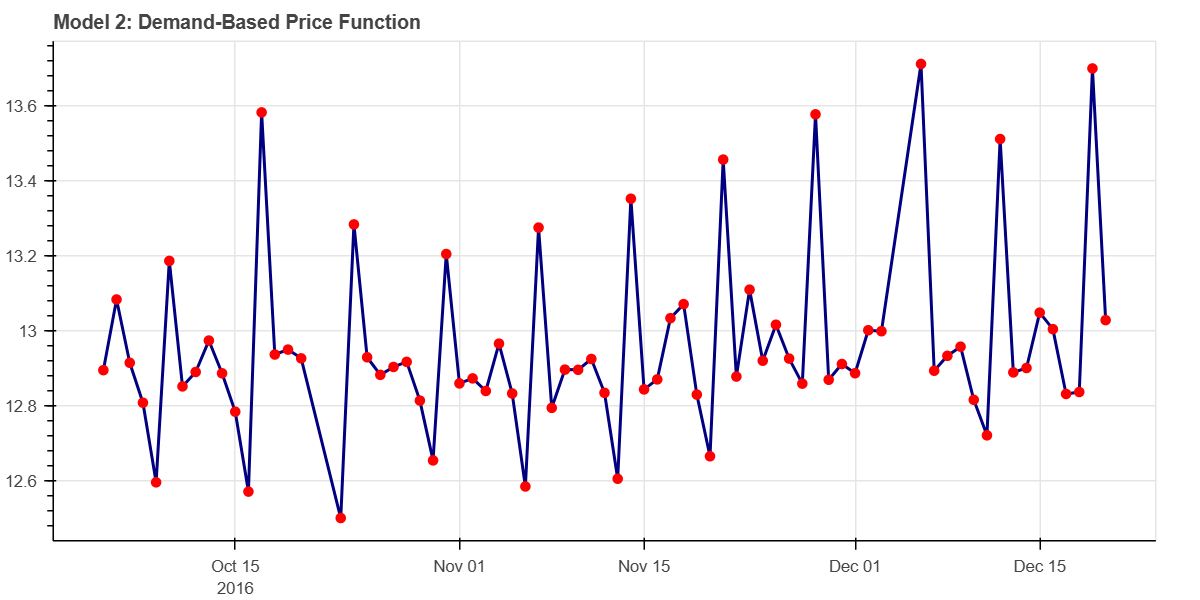

In [15]:
# %%capture --no-display
# pw.run()

**Model 3: Competitive Pricing Model**

In [16]:
import pathway as pw
import datetime
import panel as pn
import bokeh.plotting

fmt = "%Y-%m-%d %H:%M:%S"
data_with_time3 = data3.with_columns(
    t = data3.Timestamp.dt.strptime(fmt=fmt),
    day = data3.Timestamp.dt.strptime(fmt=fmt).dt.strftime("%Y-%m-%dT00:00:00"),
)

alpha = 0.4
beta = 0.1
gamma = 0.15
delta = 0.1
epsilon = 0.05
base_price = 10.0
lambda_val = 0.7

data_casted = data_with_time3.with_columns(
    occupancy_f = pw.cast(float, data_with_time3.Occupancy),
    capacity_f = pw.cast(float, data_with_time3.Capacity),
    latitude_f = pw.cast(float, data_with_time3.Latitude),
    longitude_f = pw.cast(float, data_with_time3.Longitude),
    traffic_f = pw.apply_with_type(
        lambda x: 0.0 if str(x).lower() == "low"
            else 1.0 if str(x).lower() == "average"
            else 2.0 if str(x).lower() == "high"
            else float('nan'),
        float,
        data_with_time3.TrafficConditionNearby
    ),
    queue_f = pw.cast(float, data_with_time3.QueueLength),
    special_f = pw.cast(float, data_with_time3.IsSpecialDay),
    vehicle_weight = pw.if_else(
        data_with_time3.VehicleType == "car", 1.0,
        pw.if_else(
            data_with_time3.VehicleType == "bike", 0.5,
            pw.if_else(
                data_with_time3.VehicleType == "truck", 1.5,
                1.0
            )
        )
    )
)

data_demand = data_casted.with_columns(
    occ_ratio = pw.this.occupancy_f / pw.this.capacity_f,
    demand = (
        alpha * (pw.this.occupancy_f / pw.this.capacity_f) +
        beta * pw.this.queue_f +
        gamma * pw.this.traffic_f +
        delta * pw.this.special_f +
        epsilon * pw.this.vehicle_weight
    )
)

window3_base = (
    data_demand.windowby(
        pw.this.t,
        instance=pw.this.day,
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t=pw.this._pw_window_end,
        avg_demand = pw.reducers.avg(pw.this.demand),
        min_demand = pw.reducers.min(pw.this.demand),
        max_demand = pw.reducers.max(pw.this.demand),
        avg_latitude = pw.reducers.avg(pw.this.latitude_f),
        avg_longitude = pw.reducers.avg(pw.this.longitude_f),
        lot_count = pw.reducers.count()
    )
)

window3_norm = window3_base.with_columns(
    normalized_demand = pw.if_else(
        window3_base.max_demand == window3_base.min_demand,
        0.0,
        (window3_base.avg_demand - window3_base.min_demand) / (window3_base.max_demand - window3_base.min_demand)
    ),
    competition_factor = pw.apply_with_type(
        lambda count: max(0.0, min(1.0, 1.0 - (count - 1) / 10.0)), float, window3_base.lot_count
    ),
    location_premium = pw.apply_with_type(
        lambda lat, lon: 0.1 if (lat > 40.7 and lon < -73.9) else 0.0,
        float, window3_base.avg_latitude, window3_base.avg_longitude
    )
)

window3_price = window3_norm.with_columns(
    price = base_price * (
        1 + lambda_val * window3_norm.normalized_demand
        + 0.2 * window3_norm.location_premium
        - 0.2 * (1 - window3_norm.competition_factor)
    )
)

window3 = window3_price.with_columns(
    price_bounded = pw.apply(lambda x: max(5.0, min(25.0, x)), window3_price.price)
)

pn.extension()

def competitive_plot(source):
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Model 3: Competitive Pricing Model",
        x_axis_type="datetime",
    )
    fig.line("t", "price_bounded", source=source, line_width=2, color="navy")
    fig.circle("t", "price_bounded", source=source, size=6, color="red")
    return fig

viz3 = window3.plot(competitive_plot, sorting_col="t")
pn.Column(viz3).servable()

Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

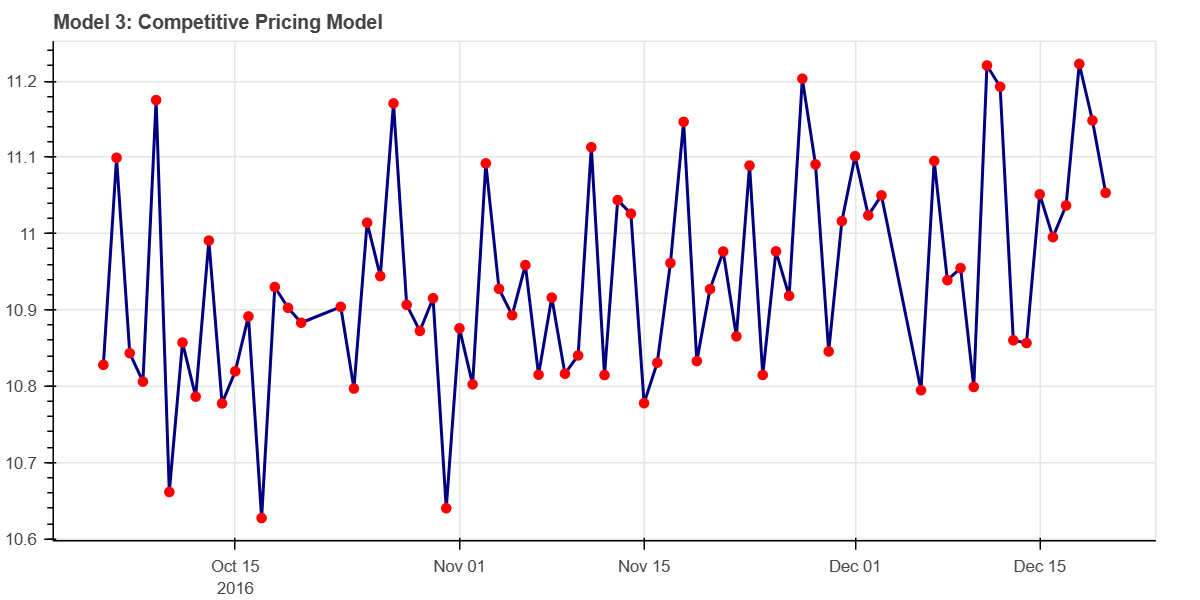

In [17]:
%%capture --no-display
pw.run()

Output()